In [1]:
import pandas as pd
import sqlite3

In [3]:
cnx = sqlite3.connect('foo.db')

In [128]:
df_customers = pd.read_sql_query("SELECT * FROM olist_customers_dataset", cnx)
df_geolocations = pd.read_sql_query("SELECT * FROM olist_geolocation_dataset", cnx)
df_orderitems = pd.read_sql_query("SELECT * FROM olist_order_items_dataset", cnx)
df_payments = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", cnx)
df_reviews = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset", cnx)
df_orders = pd.read_sql_query("SELECT * FROM olist_orders_dataset", cnx)
df_products = pd.read_sql_query("SELECT * FROM olist_products_dataset", cnx)
df_sellers = pd.read_sql_query("SELECT * FROM olist_sellers_dataset", cnx)

In [130]:
# Langkah 1: Menghitung jumlah order untuk setiap customer_id
order_counts = df_orders.groupby('customer_id').size().reset_index(name='order_count')

# Langkah 2: Menggabungkan dengan df_customers untuk mendapatkan customer_unique_id
order_counts = pd.merge(order_counts, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# Langkah 3: Mengelompokkan berdasarkan customer_unique_id
final_counts = order_counts.groupby('customer_unique_id')['order_count'].sum().reset_index()


In [132]:
final_counts

,customer_unique_id,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1
96092,fffea47cd6d3cc0a88bd621562a9d061,1
96093,ffff371b4d645b6ecea244b27531430a,1
96094,ffff5962728ec6157033ef9805bacc48,1


In [134]:
def classify_frequency(count):
    if count < 4:
        return 'rendah'
    elif 4 <= count <= 8:
        return 'menengah'
    else:
        return 'tinggi'

final_counts['class'] = final_counts['order_count'].apply(classify_frequency)

In [136]:
final_counts

,customer_unique_id,order_count,class
0,0000366f3b9a7992bf8c76cfdf3221e2,1,rendah
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,rendah
2,0000f46a3911fa3c0805444483337064,1,rendah
3,0000f6ccb0745a6a4b88665a16c9f078,1,rendah
4,0004aac84e0df4da2b147fca70cf8255,1,rendah
...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,rendah
96092,fffea47cd6d3cc0a88bd621562a9d061,1,rendah
96093,ffff371b4d645b6ecea244b27531430a,1,rendah
96094,ffff5962728ec6157033ef9805bacc48,1,rendah


In [138]:
final_counts.value_counts("class")

class
rendah      96047
menengah       47
tinggi          2
Name: count, dtype: int64

In [140]:
final_counts[final_counts['class'] == "tinggi"]

,customer_unique_id,order_count,class
23472,3e43e6105506432c953e165fb2acf44c,9,tinggi
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17,tinggi


In [176]:
final_counts.groupby('class').agg({'order_count':['min','max','mean','median','count']})

order_count                             
                 min max       mean median  count
class                                            
menengah           4   7   4.617021    4.0     47
rendah             1   3   1.032807    1.0  96047
tinggi             9  17  13.000000   13.0      2

In [ ]:
final_counts.query('order_count>0')['order_count'].describe(percentiles=[0.5,0.8,0.9,0.95,0.99,0.999])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Contoh DataFrame (silakan sesuaikan dengan data Anda)
# df = pd.read_csv('path_to_your_data.csv')

# Misalkan DataFrame-nya seperti ini:
df = final_counts

# Hitung jumlah customer per class
customer_per_class = df['class'].value_counts().reset_index()
customer_per_class.columns = ['class', 'customer_count']

# Buat pie plot menggunakan Plotly
fig = px.pie(customer_per_class, 
             names='class', 
             values='customer_count', 
             title='Distribusi Customer berdasarkan Class',
             hole=0.3)

# Tambahkan label persentase dan total count sebagai hover tooltips
fig.update_traces(textposition='inside', 
                  textinfo='percent+label', 
                  hovertemplate='Class: %{label}<br>Customer Count: %{value}<br>Percentage: %{percent}')

# Tampilkan plot
fig.show()


STEP 7: Order Behaviour

In [ ]:
import pandas as pd

# Menggabungkan df_orders dengan df_customers untuk mendapatkan customer_unique_id
df_orders_cust = pd.merge(df_orders, df_customers, on='customer_id', how='inner')

# Menggabungkan df_orderitems dengan df_orders untuk mendapatkan customer_unique_id di df_orderitems
df_orderitems_orders = pd.merge(df_orderitems, df_orders_cust[['order_id', 'customer_unique_id']], on='order_id', how='inner')

# Menghitung jumlah item yang dipesan untuk setiap pelanggan
df_order_count = df_orderitems_orders.groupby('customer_unique_id').agg(
    total_orders=('order_id', 'nunique'),  # Menghitung jumlah pesanan unik
    total_items=('order_item_id', 'size')  # Menghitung jumlah item yang dipesan
).reset_index()

# Menghitung rata-rata jumlah item yang dipesan per pesanan untuk setiap pelanggan
df_order_count['avg_items_per_order'] = df_order_count['total_items'] / df_order_count['total_orders']

# Menambahkan kolom frekuensi pesanan
df_order_count['order_frequency'] = df_order_count['total_orders'].apply(lambda x: 'sedikit' if x <= 5 else 'banyak')



In [ ]:
df_order_count

In [ ]:
df_order_count.value_counts("order_frequency")

In [15]:
df_products.dtypes

product_id                    object
product_category_name         object
product_name_lenght           object
product_description_lenght    object
product_photos_qty            object
product_weight_g              object
product_length_cm             object
product_height_cm             object
product_width_cm              object
dtype: object

In [17]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37,402,4,625,20,17,13
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45,67,2,12300,40,40,40
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41,971,1,1700,16,19,16
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50,799,1,1400,27,7,27
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60,156,2,700,31,13,20


In [25]:
import pandas as pd

# Mengonversi kolom product_weight_g menjadi numerik (integer/float)
df_products['product_weight_g'] = pd.to_numeric(df_products['product_weight_g'], errors='coerce')

# Mengelompokkan data berdasarkan kategori produk dan menghitung rata-rata serta simpangan baku
df_product_stats = df_products.groupby('product_category_name').agg(
    average_weight=('product_weight_g', 'mean'),  # Menghitung rata-rata berat barang
    standard_deviation_weight=('product_weight_g', 'std')  # Menghitung simpangan baku berat barang
).reset_index()

# Tampilkan DataFrame hasil
df_product_stats


,product_category_name,average_weight,standard_deviation_weight
0,,2250.765189,4429.016600
1,agro_industria_e_comercio,5263.405405,5913.073074
2,alimentos,923.414634,1222.642079
3,alimentos_bebidas,1307.932692,2011.971927
4,artes,1691.763636,2551.614333
...,...,...,...
69,sinalizacao_e_seguranca,2969.817204,6179.868591
70,tablets_impressao_imagem,381.444444,303.745416
71,telefonia,236.506173,335.883175
72,telefonia_fixa,660.827586,811.213897


In [27]:
import pandas as pd

# Mengonversi kolom order_purchase_timestamp menjadi datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Ekstraksi informasi bulan, hari, dan waktu
df_orders['month'] = df_orders['order_purchase_timestamp'].dt.month
df_orders['day_of_week'] = df_orders['order_purchase_timestamp'].dt.day_name()  # Nama hari (Senin, Selasa, dst.)
df_orders['hour'] = df_orders['order_purchase_timestamp'].dt.hour

# Klasifikasi waktu ke dalam pagi, sore, malam
def classify_time(hour):
    if 5 <= hour < 12:
        return 'Pagi'
    elif 12 <= hour < 18:
        return 'Sore'
    else:
        return 'Malam'

df_orders['time_of_day'] = df_orders['hour'].apply(classify_time)

# Mengelompokkan data berdasarkan bulan, hari, dan waktu (pagi, sore, malam)
df_grouped = df_orders.groupby(['month', 'day_of_week', 'time_of_day']).size().reset_index(name='order_count')

# Tampilkan DataFrame hasil
df_grouped

,month,day_of_week,time_of_day,order_count
0,1,Friday,Malam,365
1,1,Friday,Pagi,240
2,1,Friday,Sore,419
3,1,Monday,Malam,551
4,1,Monday,Pagi,273
...,...,...,...,...
247,12,Tuesday,Pagi,206
248,12,Tuesday,Sore,334
249,12,Wednesday,Malam,334
250,12,Wednesday,Pagi,183


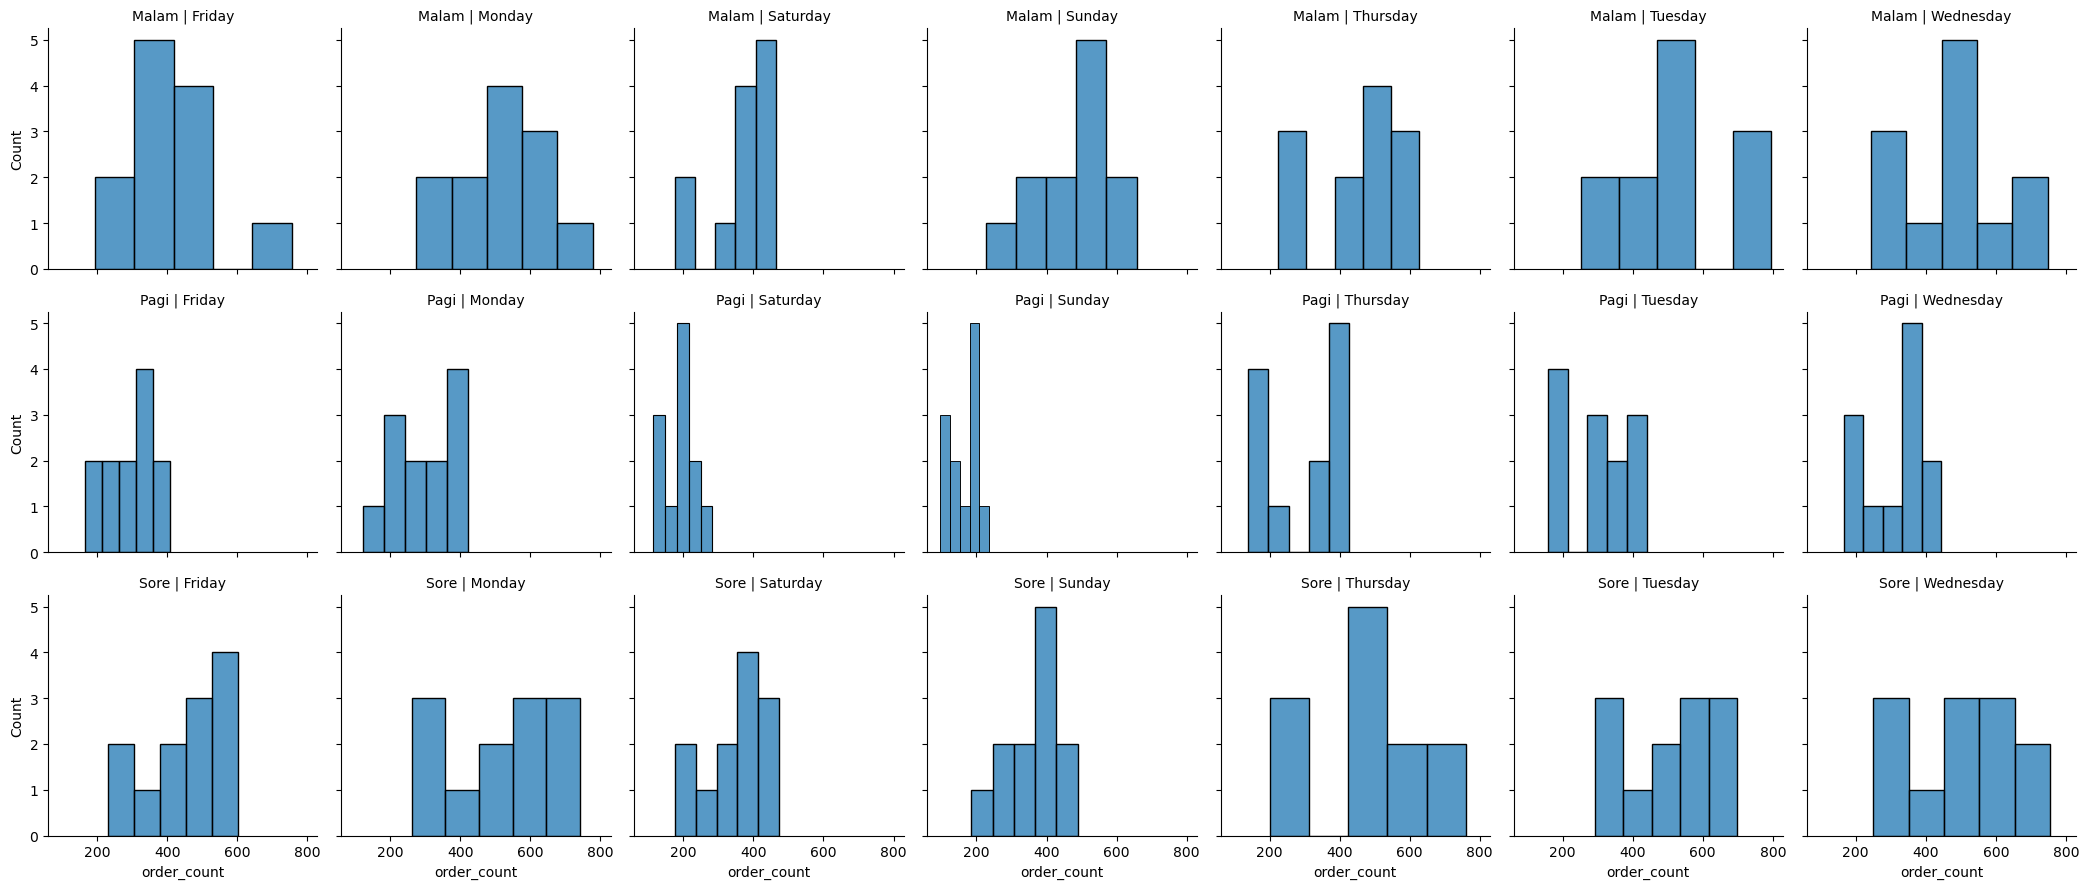

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_grouped, col="day_of_week",  row="time_of_day")
g.map_dataframe(sns.histplot, x="order_count")
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

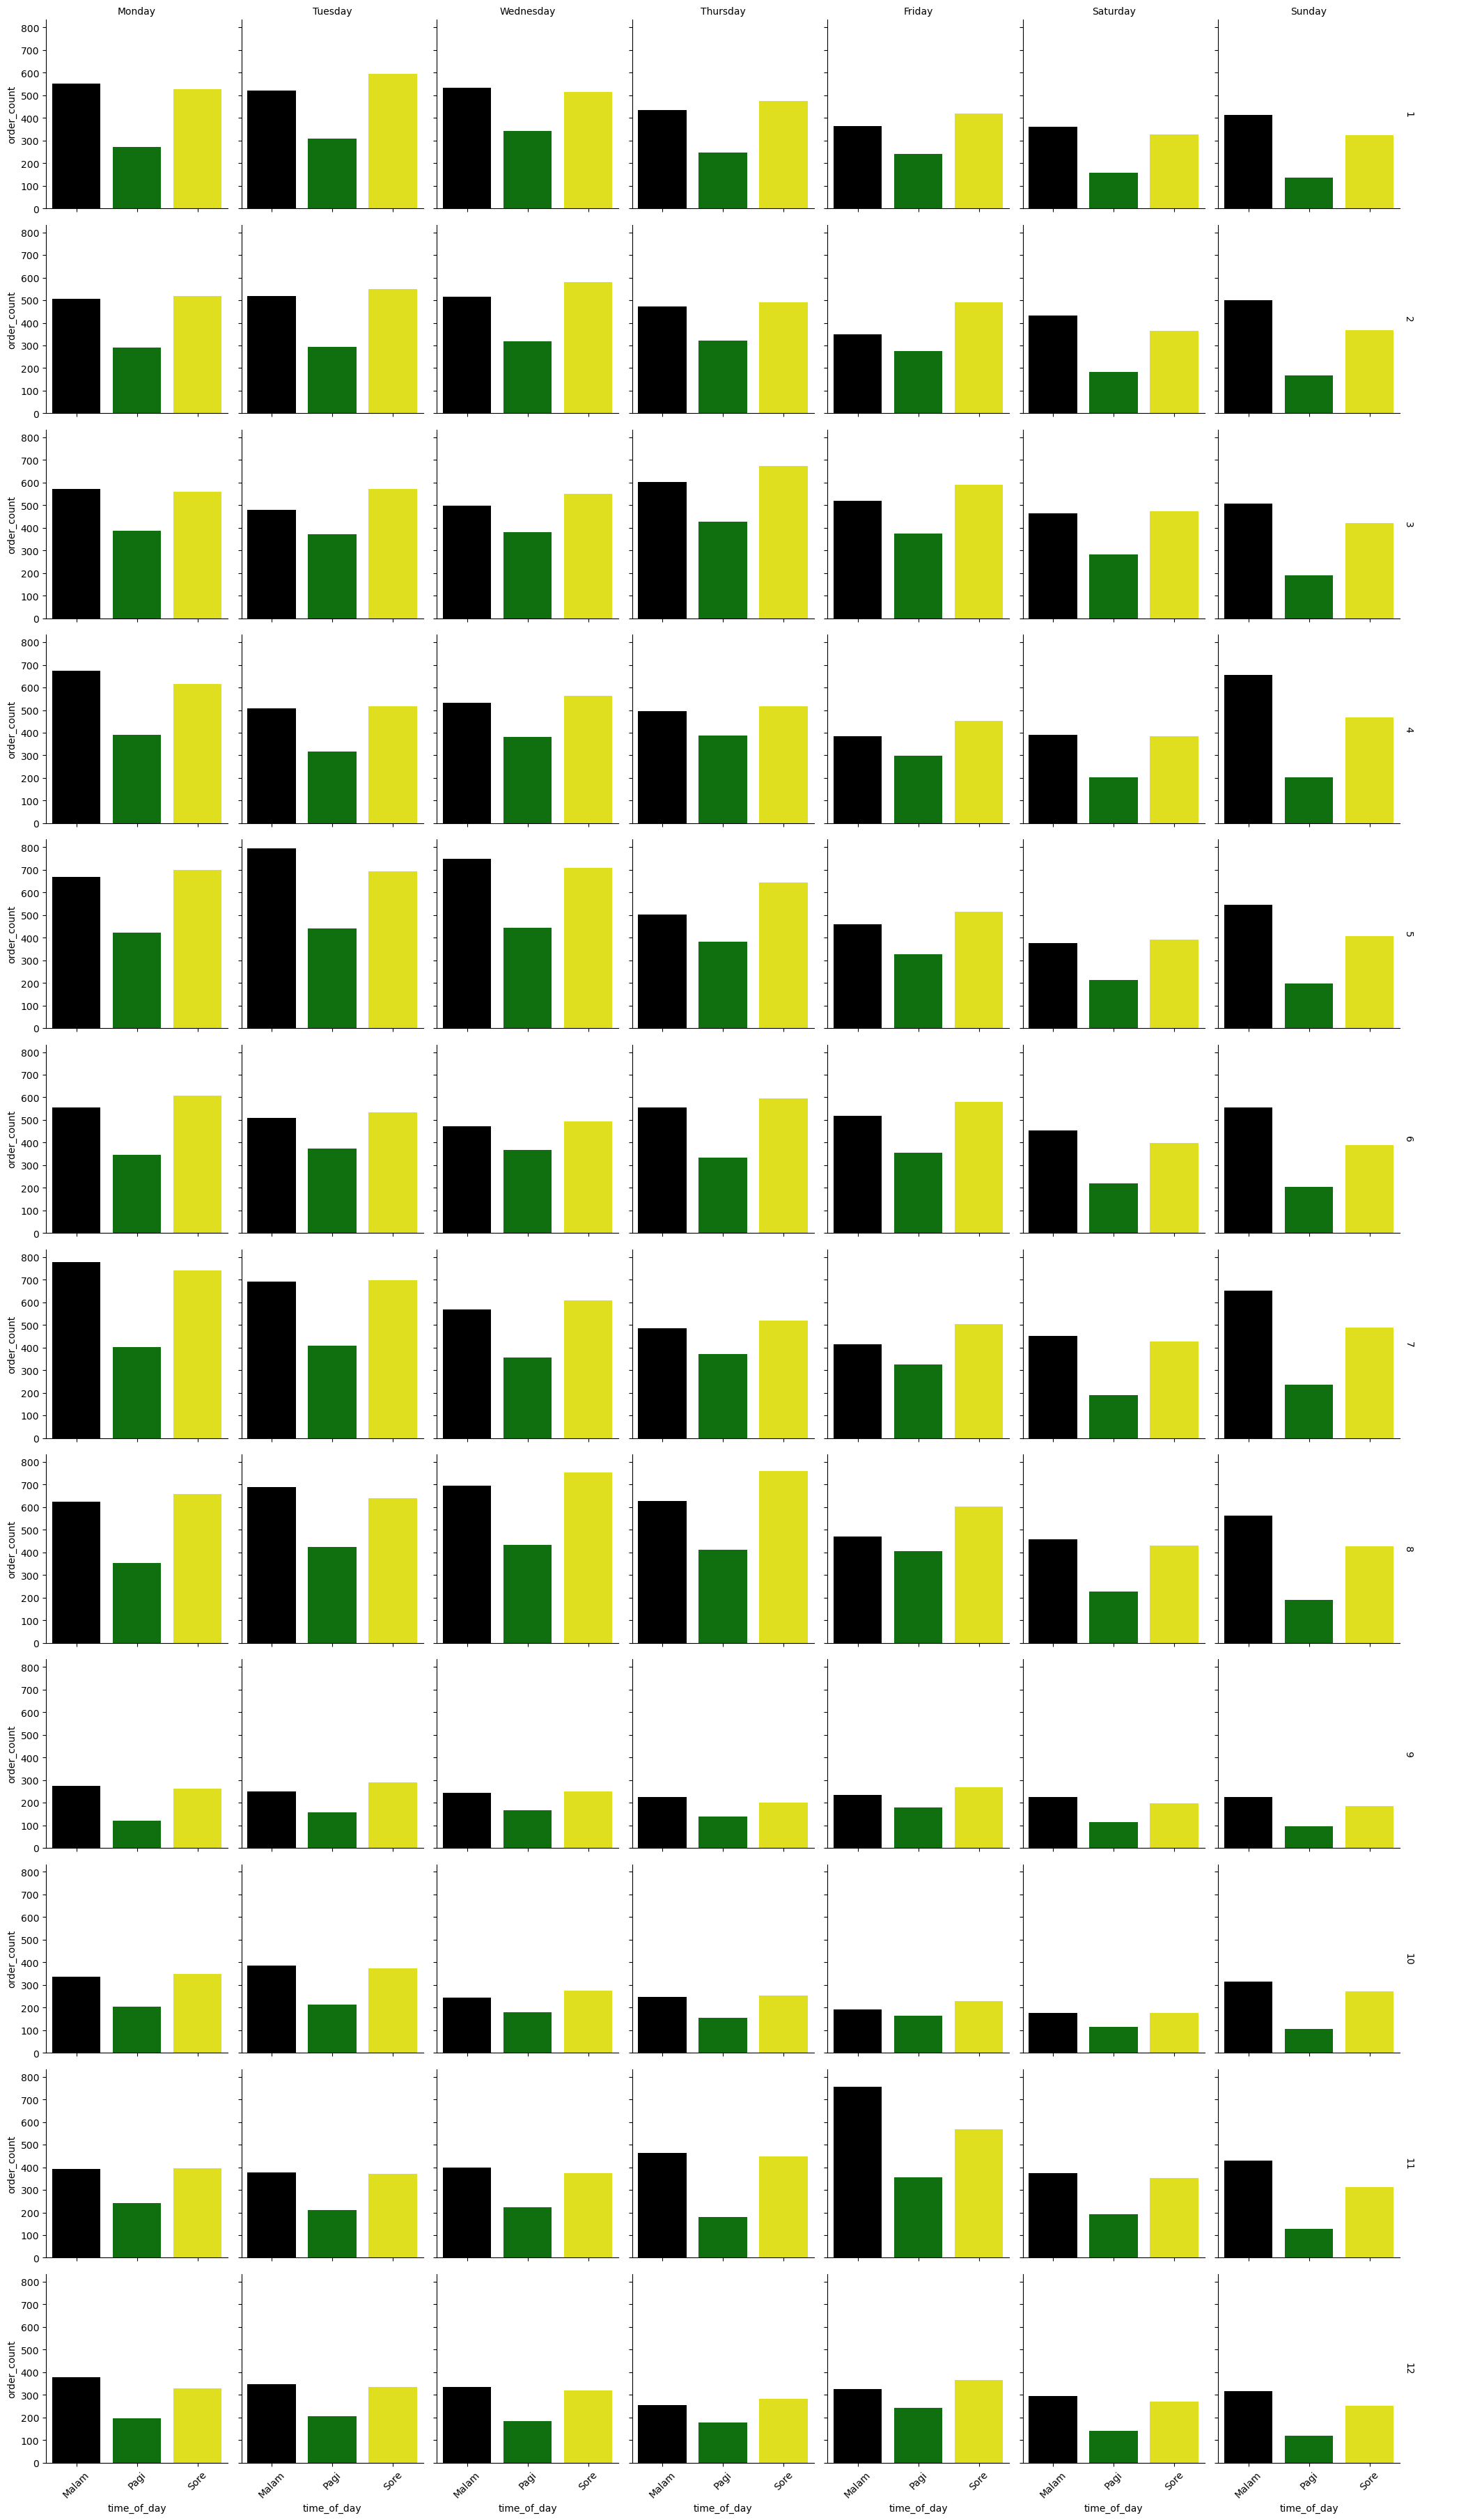

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definisikan urutan hari dalam seminggu (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Definisikan warna yang diinginkan untuk masing-masing time_of_day
custom_palette = {'Pagi': 'green', 'Sore': 'yellow', 'Malam': 'Black'}

# Menggunakan seaborn's FacetGrid untuk membuat visualisasi
g = sns.FacetGrid(df_grouped, col="day_of_week", row="month", margin_titles=True, col_order=day_order)

# Menggunakan sns.barplot untuk menggambarkan hubungan antara time_of_day dan order_count, dengan hue dan palette custom
g.map_dataframe(sns.barplot, x="time_of_day", y="order_count", hue="time_of_day", hue_order=['Pagi', 'Sore', 'Malam'], palette=custom_palette)

# Menambahkan legenda untuk time_of_day
g.add_legend()

# Mengatur judul kolom dan baris berdasarkan template
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Memutar label x-axis agar lebih terbaca
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

# Menampilkan plot
plt.show()


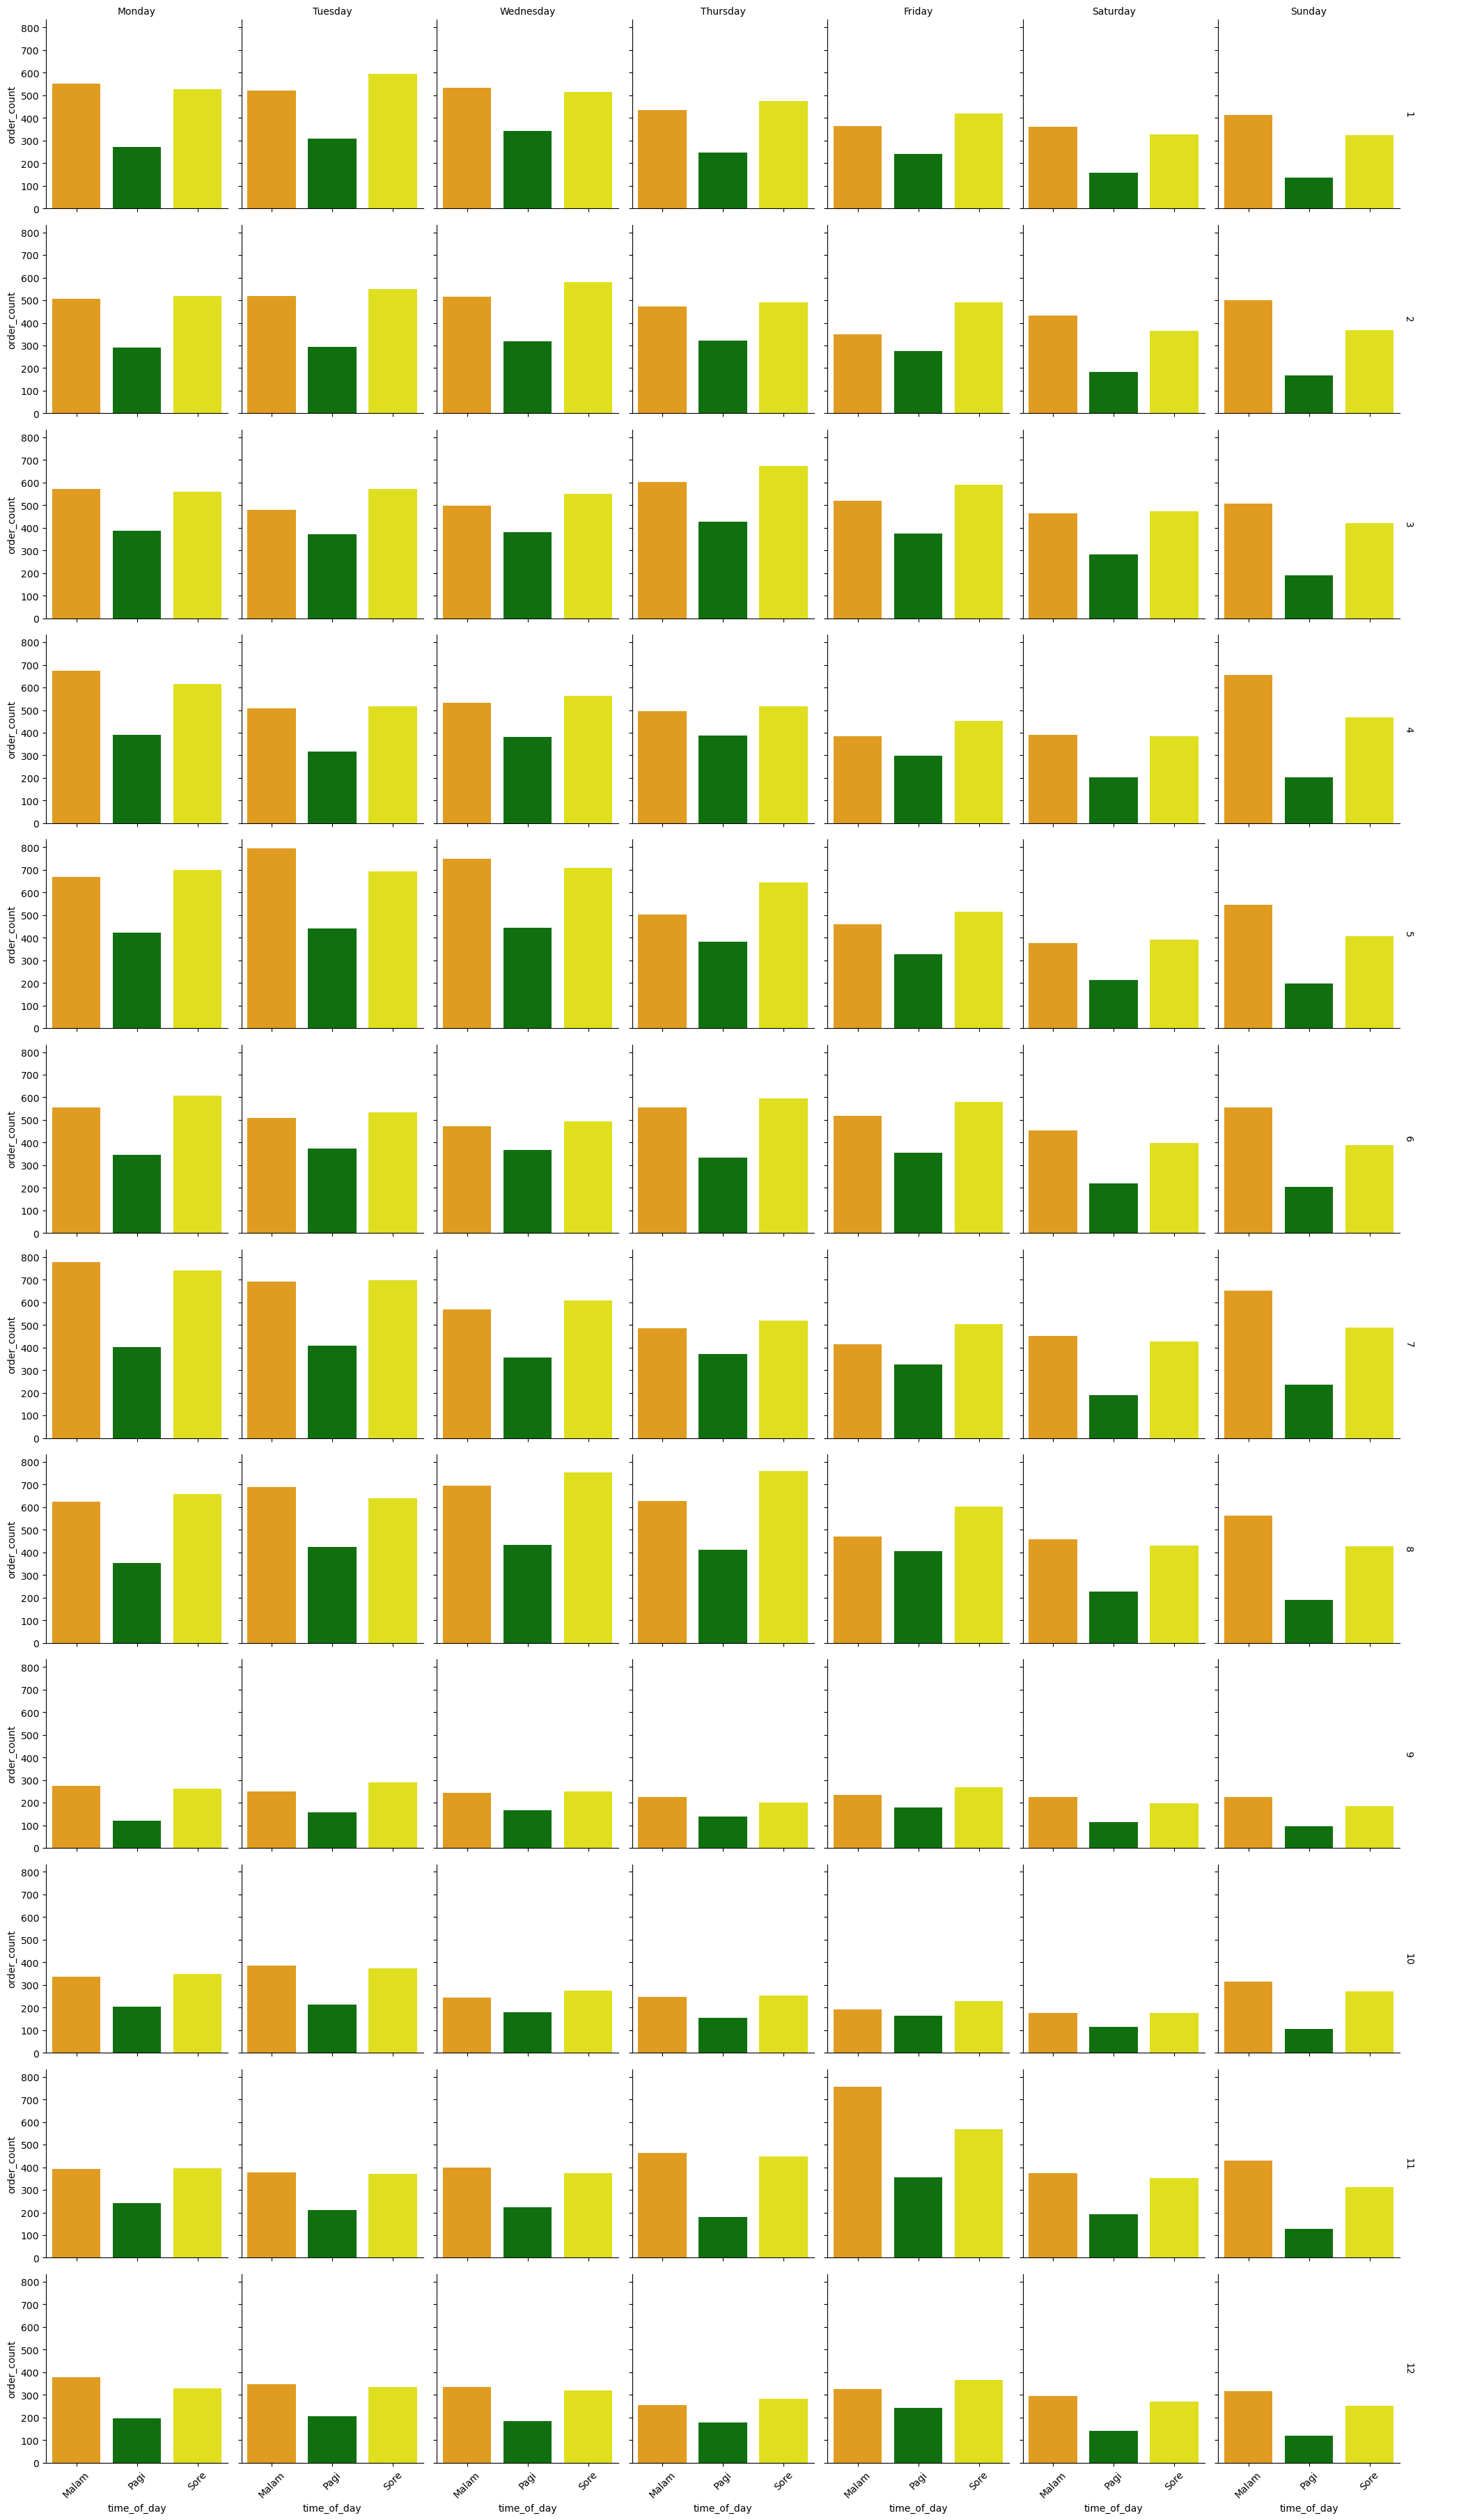

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definisikan urutan hari dalam seminggu (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Definisikan warna yang diinginkan untuk masing-masing time_of_day
custom_palette = {'Pagi': 'green', 'Sore': 'yellow', 'Malam': 'orange'}

# Menggunakan seaborn's FacetGrid untuk membuat visualisasi
g = sns.FacetGrid(df_grouped, col="day_of_week", row="month", margin_titles=True, col_order=day_order)

# Menggunakan sns.barplot untuk menggambarkan hubungan antara time_of_day dan order_count, dengan hue dan palette custom
g.map_dataframe(sns.barplot, x="time_of_day", y="order_count", hue="time_of_day", hue_order=['Pagi', 'Sore', 'Malam'], palette=custom_palette)

# Menambahkan legenda untuk time_of_day
g.add_legend()

# Mengatur judul kolom dan baris berdasarkan template
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Memutar label x-axis agar lebih terbaca
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

# Menyimpan plot sebagai file gambar (misalnya: 'output_chart.png')
plt.savefig('output_chart.png', dpi=300, bbox_inches='tight')

# Menampilkan plot
plt.show()

In [51]:
import pandas as pd

# Menggabungkan df_orders dan df_orderitems berdasarkan 'order_id'
df_mergeded = pd.merge(df_orders, df_orderitems, on='order_id')

# Menghitung nilai total pesanan (price + freight_value) untuk setiap order
df_mergeded['price'] = pd.to_numeric(df_mergeded['price'], errors='coerce')
df_mergeded['freight_value'] = pd.to_numeric(df_mergeded['freight_value'], errors = 'coerce')
df_mergeded['total_order_value'] = df_mergeded['price'] + df_mergeded['freight_value']

# Mengelompokkan berdasarkan 'customer_id' dan menghitung nilai rata-rata total pesanan per customer
df_group = df_mergeded.groupby('customer_id').agg(
    avg_order_value=('total_order_value', 'mean')  # Rata-rata nilai total pesanan
).reset_index()

# Mengklasifikasikan harga pesanan rata-rata
def classify_price(avg_order_value):
    if avg_order_value > 2500:
        return 'Mahal'
    elif 1000 <= avg_order_value <= 2500:
        return 'Normal'
    else:
        return 'Murah'

df_group['price_category'] = df_group['avg_order_value'].apply(classify_price)

# Menampilkan DataFrame hasil
df_group


,customer_id,avg_order_value,price_category
0,00012a2ce6f8dcda20d059ce98491703,114.74,Murah
1,000161a058600d5901f007fab4c27140,67.41,Murah
2,0001fd6190edaaf884bcaf3d49edf079,195.42,Murah
3,0002414f95344307404f0ace7a26f1d5,179.35,Murah
4,000379cdec625522490c315e70c7a9fb,107.01,Murah
...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,91.91,Murah
98662,fffecc9f79fd8c764f843e9951b11341,81.36,Murah
98663,fffeda5b6d849fbd39689bb92087f431,63.13,Murah
98664,ffff42319e9b2d713724ae527742af25,214.13,Murah


In [53]:
df_group.value_counts('price_category')

price_category
Murah     97704
Normal      896
Mahal        66
Name: count, dtype: int64

In [57]:
import pandas as pd

# Menggabungkan df_orders, df_payments, df_orderitems, dan df_products berdasarkan order_id dan product_id
df_merged = pd.merge(df_orders, df_payments, on='order_id')
df_merged = pd.merge(df_merged, df_orderitems, on='order_id')
df_merged = pd.merge(df_merged, df_products, on='product_id')

# Menghitung metode pembayaran paling populer per customer
df_payment_popular = df_merged.groupby(['customer_unique_id', 'payment_type']).size().reset_index(name='payment_count')
df_payment_popular = df_payment_popular.loc[df_payment_popular.groupby('customer_unique_id')['payment_count'].idxmax()]

# Menghitung preferensi kategori produk setiap customer
df_product_preference = df_merged.groupby(['customer_unique_id', 'product_category_name']).size().reset_index(name='category_count')
df_product_preference = df_product_preference.loc[df_product_preference.groupby('customer_id')['category_count'].idxmax()]

# Menggabungkan hasil penghitungan metode pembayaran dan kategori produk
df_customer_summary = pd.merge(df_payment_popular[['customer_id', 'payment_type']], 
                               df_product_preference[['customer_id', 'product_category_name']], 
                               on='customer_id')

# Menampilkan hasil DataFrame
df_customer_summary

,customer_id,payment_type,product_category_name
0,00012a2ce6f8dcda20d059ce98491703,credit_card,brinquedos
1,000161a058600d5901f007fab4c27140,credit_card,beleza_saude
2,0001fd6190edaaf884bcaf3d49edf079,credit_card,bebes
3,0002414f95344307404f0ace7a26f1d5,boleto,cool_stuff
4,000379cdec625522490c315e70c7a9fb,boleto,cama_mesa_banho
...,...,...,...
98660,fffcb937e9dd47a13f05ecb8290f4d3e,credit_card,livros_interesse_geral
98661,fffecc9f79fd8c764f843e9951b11341,voucher,cama_mesa_banho
98662,fffeda5b6d849fbd39689bb92087f431,credit_card,telefonia
98663,ffff42319e9b2d713724ae527742af25,credit_card,cama_mesa_banho


In [59]:
import pandas as pd

# Menggabungkan df_orderitems dengan df_products untuk mendapatkan kategori produk
df_order_product = pd.merge(df_orderitems, df_products, on='product_id')

In [61]:
df_order_product

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58,598,4,650.0,28,9,14
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56,239,2,30000.0,50,30,40
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59,695,2,3050.0,33,13,33
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42,480,1,200.0,16,10,15
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59,409,1,3750.0,35,40,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43,1002,3,10150.0,89,15,40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31,232,1,8950.0,45,26,38
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43,869,1,967.0,21,24,19
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56,1306,1,100.0,20,20,20


In [67]:
import pandas as pd

# Menggabungkan df_orderitems dengan df_products untuk mendapatkan kategori produk
df_order_product = pd.merge(df_orderitems, df_products, on='product_id')
df_order_product['price'] = pd.to_numeric(df_order_product['price'], errors='coerce')
df_order_product['freight_value'] = pd.to_numeric(df_order_product['freight_value'], errors = 'coerce')
df_order_product['total_order_value'] = df_order_product['price'] + df_order_product['freight_value']
# Menghitung freq_orders dan volume_orders berdasarkan product_category_name
df_mergeded['total_order_value'] = df_mergeded['price'] + df_mergeded['freight_value']
df_grouped = df_order_product.groupby('product_category_name').agg(
    freq_orders=('order_id', 'count'),        # Menghitung jumlah order (frekuensi pesanan)
    volume_orders=('price', 'sum'),            # Menghitung total nilai pesanan (volume pesanan)
    volume_freight=('freight_value', 'sum'),
    volume_total_order=('total_order_value', 'sum')
).reset_index()

# Menampilkan DataFrame hasil
df_grouped


,product_category_name,freq_orders,volume_orders,volume_freight,volume_total_order
0,,1603,179535.28,28169.81,207705.09
1,agro_industria_e_comercio,212,72530.47,5843.60,78374.07
2,alimentos,510,29393.41,7271.03,36664.44
3,alimentos_bebidas,278,15179.48,4507.99,19687.47
4,artes,209,24202.64,4045.17,28247.81
...,...,...,...,...,...
69,sinalizacao_e_seguranca,199,21509.23,6507.82,28017.05
70,tablets_impressao_imagem,83,7528.41,1226.20,8754.61
71,telefonia,4545,323667.53,71215.79,394883.32
72,telefonia_fixa,264,59583.00,4637.81,64220.81


STEP 8: Review Customer

In [88]:
import pandas as pd

# Menggabungkan df_reviews dengan df_orders untuk mendapatkan customer_id terkait setiap ulasan
df_review_orders = pd.merge(df_reviews, df_orders, on='order_id')

# Menggabungkan dengan df_customers untuk mendapatkan informasi pelanggan
df_review_customers = pd.merge(df_review_orders, df_customers, on='customer_id')
df_review_customers['review_score'] = pd.to_numeric(df_review_customers['review_score'], errors='coerce')

# Menghitung skor ulasan rata-rata untuk setiap customer_unique_id
df_customer_reviews = df_review_customers.groupby('customer_unique_id').agg(
    avg_review_score=('review_score', 'mean')
).reset_index()

# Menambahkan kolom tingkat kepuasan
df_customer_reviews['satisfaction'] = df_customer_reviews['avg_review_score'].apply(
    lambda x: 'Puas' if x >= 4 else 'Tidak Puas'
)

# Menampilkan hanya kolom customer_unique_id, avg_review_score, dan satisfaction
df_result = df_customer_reviews[['customer_unique_id', 'avg_review_score', 'satisfaction']]

# Menampilkan hasil akhir
df_result


,customer_unique_id,avg_review_score,satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,Puas
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,Puas
2,0000f46a3911fa3c0805444483337064,3.0,Tidak Puas
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,Puas
4,0004aac84e0df4da2b147fca70cf8255,5.0,Puas
...,...,...,...
95375,fffcf5a5ff07b0908bd4e2dbc735a684,5.0,Puas
95376,fffea47cd6d3cc0a88bd621562a9d061,4.0,Puas
95377,ffff371b4d645b6ecea244b27531430a,5.0,Puas
95378,ffff5962728ec6157033ef9805bacc48,5.0,Puas


In [90]:
df_result.value_counts('satisfaction')

satisfaction
Puas          73302
Tidak Puas    22078
Name: count, dtype: int64

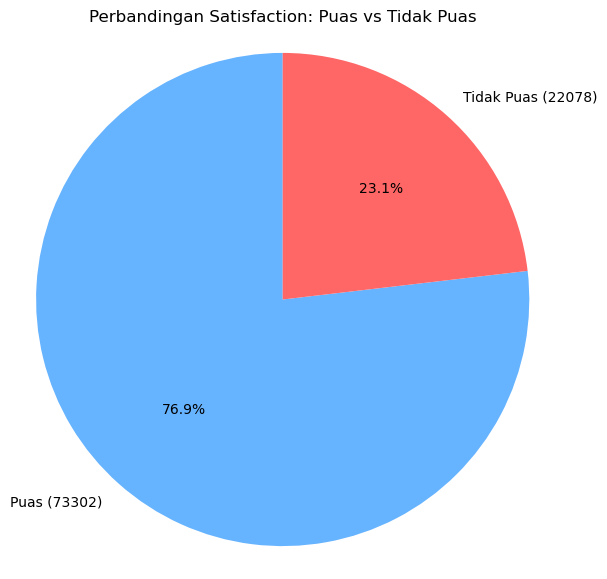

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Menghitung jumlah customer yang puas dan tidak puas
satisfaction_counts = df_result['satisfaction'].value_counts()

# Membuat pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    satisfaction_counts,
    labels=[f'{label} ({count})' for label, count in satisfaction_counts.items()],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff6666']
)

# Menambahkan judul
plt.title('Perbandingan Satisfaction: Puas vs Tidak Puas')

# Menampilkan pie chart
plt.axis('equal')  # Agar pie chart berbentuk bulat
plt.show()


In [154]:
# # Langkah 1: Menghitung jumlah order untuk setiap customer_id
# order_counts = df_orders.groupby('customer_id').size().reset_index(name='order_count')

# # Langkah 2: Menggabungkan dengan df_customers untuk mendapatkan customer_unique_id
# order_counts = pd.merge(order_counts, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# # Langkah 3: Mengelompokkan berdasarkan customer_unique_id
# final_counts = order_counts.groupby('customer_unique_id')['order_count'].sum().reset_index()

import pandas as pd

# Menggabungkan df_reviews dengan df_orders untuk mendapatkan customer_id terkait setiap ulasan
df_review_orders = pd.merge(df_reviews, df_orders, on='order_id')

# Menggabungkan dengan df_customers untuk mendapatkan informasi pelanggan
df_review_customers = pd.merge(df_review_orders, df_customers, on='customer_id')
df_review_customers['review_score'] = pd.to_numeric(df_review_customers['review_score'], errors='coerce')

# Memilih ulasan yang memiliki judul dan pesan (non-null)
df_reviews_filtered = df_review_customers.dropna(subset=['review_comment_title', 'review_comment_message'])

# Menghitung total ulasan untuk setiap pelanggan
df_total_reviews = df_reviews_filtered.groupby('customer_unique_id').size().reset_index(name='total_reviews')

In [158]:
# Menggabungkan tabel total ulasan dengan total pesanan berdasarkan customer_id
df_merged = pd.merge(final_counts,df_total_reviews, on='customer_unique_id', how='left')

In [160]:
df_merged

,customer_unique_id,order_count,class,total_reviews
0,0000366f3b9a7992bf8c76cfdf3221e2,1,rendah,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,rendah,1.0
2,0000f46a3911fa3c0805444483337064,1,rendah,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,rendah,1.0
4,0004aac84e0df4da2b147fca70cf8255,1,rendah,1.0
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,rendah,1.0
96092,fffea47cd6d3cc0a88bd621562a9d061,1,rendah,1.0
96093,ffff371b4d645b6ecea244b27531430a,1,rendah,1.0
96094,ffff5962728ec6157033ef9805bacc48,1,rendah,1.0


In [172]:
# Menggabungkan tabel total ulasan dengan total pesanan berdasarkan customer_id
df_merged = pd.merge(final_counts,df_total_reviews, on='customer_unique_id', how='left')

# Menambahkan kolom rasio ulasan per transaksi (total_reviews / total_orders)
df_merged['review_to_order_ratio'] = df_merged['total_reviews'] / df_merged['order_count']
df_merged = df_merged.drop(['class'], axis=1)

# Menampilkan DataFrame hasil
df_merged

,customer_unique_id,order_count,total_reviews,review_to_order_ratio
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,1.0
2,0000f46a3911fa3c0805444483337064,1,1.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,1,1.0,1.0
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,1.0,1.0
96092,fffea47cd6d3cc0a88bd621562a9d061,1,1.0,1.0
96093,ffff371b4d645b6ecea244b27531430a,1,1.0,1.0
96094,ffff5962728ec6157033ef9805bacc48,1,1.0,1.0


In [174]:
df_merged.value_counts('review_to_order_ratio')

review_to_order_ratio
1.000000    94893
1.500000      240
2.000000      164
0.500000       35
1.333333       21
1.666667       16
0.666667        3
0.333333        2
1.200000        2
1.250000        2
1.166667        1
1.400000        1
Name: count, dtype: int64

In [144]:
df_merged.value_counts('total_orders')

total_orders
1    98673
Name: count, dtype: int64

In [ ]:
final_counts.groupby('cluster').agg({'order_count':['min','max','mean','median','count']})

In [ ]:
final_counts[final_counts['cluster'] == 8]

In [178]:
import pandas as pd

# Misalkan df_customers dan df_orders sudah didefinisikan sebelumnya
# df_customers = pd.read_csv('path_to_customers.csv')
# df_orders = pd.read_csv('path_to_orders.csv')

# Langkah 1: Mengonversi kolom order_purchase_timestamp ke tipe datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Langkah 2: Melakukan merge antara df_orders dan df_customers
merged_df = pd.merge(df_orders, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# Langkah 3: Mengelompokkan data berdasarkan customer_unique_id untuk mendapatkan tanggal transaksi terakhir
last_transaction_dates = merged_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_transaction_dates.columns = ['customer_unique_id', 'last_transaction_date']

# Langkah 4: Menentukan tanggal transaksi akhir (tanggal terbaru dari seluruh transaksi)
final_transaction_date = merged_df['order_purchase_timestamp'].max()

# Langkah 5: Menambahkan kolom tanggal transaksi akhir dan menghitung selisih hari
last_transaction_dates['final_transaction_date'] = final_transaction_date
last_transaction_dates['days_difference'] = (last_transaction_dates['final_transaction_date'] - last_transaction_dates['last_transaction_date']).dt.days

# Menampilkan hasil
last_transaction_dates


,customer_unique_id,last_transaction_date,final_transaction_date,days_difference
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-10-17 17:30:18,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-10-17 17:30:18,163
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2018-10-17 17:30:18,585
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2018-10-17 17:30:18,369
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2018-10-17 17:30:18,336
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2018-10-17 17:30:18,495
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2018-10-17 17:30:18,310
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2018-10-17 17:30:18,617
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2018-10-17 17:30:18,168


In [ ]:
last_transaction_dates[last_transaction_dates['days_difference'] == 744]

In [180]:
last_transaction_dates.value_counts('days_difference')

days_difference
327    844
326    763
324    436
323    393
154    365
      ... 
47       1
34       1
40       1
725      1
30       1
Name: count, Length: 630, dtype: int64

In [ ]:
df_agg

In [182]:
import pandas as pd

# Misalkan data tersedia sebagai berikut
# df_customers = pd.read_csv('path_to_customers_data.csv')
# df_orders = pd.read_csv('path_to_orders_data.csv')

# Membuat DataFrame

# Pastikan format tanggal pada kolom 'order_purchase_timestamp'
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Gabungkan df_orders dengan df_customers untuk mendapatkan customer_unique_id
df_merged = pd.merge(df_orders, df_customers, on='customer_id', how='inner')

# Group by customer_unique_id untuk mendapatkan order pertama dan terakhir
df_grouped = df_merged.groupby('customer_unique_id').agg(
    fd_order=('order_purchase_timestamp', 'min'),  # Tanggal order pertama
    ld_order=('order_purchase_timestamp', 'max')   # Tanggal order terakhir
).reset_index()

# Hitung frekuensi pesanan pada order pertama (fd_freq)
fd_freq = df_merged[df_merged['order_purchase_timestamp'] == df_merged.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')].groupby('customer_unique_id').size().reset_index(name='fd_freq')

# Hitung frekuensi pesanan pada order terakhir (ld_freq)
ld_freq = df_merged[df_merged['order_purchase_timestamp'] == df_merged.groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')].groupby('customer_unique_id').size().reset_index(name='ld_freq')

# Gabungkan hasil frekuensi dengan df_grouped
df_grouped = pd.merge(df_grouped, fd_freq, on='customer_unique_id', how='left')
df_grouped = pd.merge(df_grouped, ld_freq, on='customer_unique_id', how='left')

# Hitung selisih frekuensi
df_grouped['selisih_freq'] = df_grouped['ld_freq'] - df_grouped['fd_freq']

# Tampilkan DataFrame hasil
df_grouped


,customer_unique_id,fd_order,ld_order,fd_freq,ld_freq,selisih_freq
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,1,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,1,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,1,0
...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-06-08 21:00:36,1,1,0
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2017-12-10 20:07:56,1,1,0
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2017-02-07 15:49:16,1,1,0
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2018-05-02 15:17:41,1,1,0


In [184]:
df_grouped[(df_grouped['selisih_freq'] > 0) | (df_grouped['selisih_freq'] < 0)]

,customer_unique_id,fd_order,ld_order,fd_freq,ld_freq,selisih_freq
2495,06a52782a04f0086d16b9c22d0e29438,2017-05-06 20:11:10,2017-05-06 20:11:11,2,1,-1
13281,23339103d82a054f9729b0554ce22e8c,2018-05-30 16:57:26,2018-06-16 11:58:28,1,2,1
14299,25f3cf83109f636d52d288fa4e797111,2018-02-25 21:01:07,2018-02-25 21:01:08,2,1,-1
17436,2e43e031f10de28e557c35ef668f9396,2017-01-26 13:15:41,2017-01-26 13:15:42,2,1,-1
20337,35ecdf6858edc6427223b64804cf028e,2017-08-05 14:55:19,2018-03-31 21:18:49,2,1,-1
25098,42befda568ea0df110b6cec63c233bea,2017-10-09 12:17:50,2018-03-23 13:44:28,1,2,1
26566,46958f708ade6b6a88b2e5aca1e66de5,2017-08-30 06:22:57,2017-08-30 06:22:58,1,2,1
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,2017-08-07 14:14:22,2018-01-24 15:15:26,2,1,-1
30808,51d91326ffc0688da14a001de38c264b,2017-08-15 21:44:47,2017-08-26 18:31:19,2,1,-1
37959,64df076fb557552498049bb07ed1cd5f,2018-04-25 10:52:10,2018-05-10 10:13:46,2,1,-1


In [186]:
df_grouped.value_counts('selisih_freq')

selisih_freq
 0    96065
-1       19
 1       12
Name: count, dtype: int64

STEP 9: Time Series Analysis

In [193]:
import pandas as pd

# Mengubah kolom timestamp menjadi datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.date

# Menggabungkan tabel df_orders dan df_orderitems berdasarkan order_id
df_merged = pd.merge(df_orderitems, df_orders, on='order_id')

# Mengelompokkan data untuk menghitung total penjualan per hari dan per produk
df_sales_per_day = df_merged.groupby(['order_purchase_timestamp', 'product_id']).agg(
    total_sales=('price', 'sum')
).reset_index()

# Menampilkan DataFrame hasil
df_sales_per_day


,order_purchase_timestamp,product_id,total_sales
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,39.99
1,2016-09-04,f293394c72c9b5fafd7023301fc21fc2,32.90
2,2016-09-05,f3c2d01a84c947b078e32bbef0718962,59.50
3,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,44.9944.9944.99
4,2016-10-02,d2998d7ced12f83f9b832f33cf6507b6,100.00
...,...,...,...
94586,2018-08-29,b6b76b074ed0d77d0f3443b12d8adb5e,99.00
94587,2018-08-29,bdcf6a834e8faa30dac3886c7a58e92e,45.90
94588,2018-08-29,c7f27c5bef2338541c772b5776403e6a,24.90
94589,2018-08-29,d04857e7b4b708ee8b8b9921163edba3,84.99


In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat visualisasi tren penjualan
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sales_per_day, x='order_purchase_timestamp', y='total_sales', hue='product_id', marker='o')

# Menambahkan label dan judul
plt.title('Tren Penjualan per Hari per Produk')
plt.xlabel('Tanggal')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=45)
plt.tight_layout()

# Menampilkan plot
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20928\2120301581.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_20928\2120301581.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1865x690212 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

In [ ]:
# import pandas as pd

# # Misalkan df_customers dan df_orders sudah didefinisikan sebelumnya
# # df_customers = pd.read_csv('path_to_customers.csv')
# # df_orders = pd.read_csv('path_to_orders.csv')

# # Mengonversi kolom order_purchase_timestamp ke tipe datetime
# df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# # Mengelompokkan data berdasarkan customer_id dan mendapatkan tanggal transaksi awal dan akhir
# df_grouped = df_orders.groupby('customer_id')['order_purchase_timestamp'].agg(['min', 'max']).reset_index()

# # Menghitung selisih hari antara transaksi awal dan akhir
# df_grouped['days_difference'] = (df_grouped['max'] - df_grouped['min']).dt.days

# # Menggabungkan dengan df_customers untuk mendapatkan customer_id
# result_df = pd.merge(df_customers[['customer_id']], df_grouped, on='customer_id', how='left')

# # Mengganti nama kolom untuk kejelasan
# result_df.columns = ['customer_id', 'first_transaction_date', 'last_transaction_date', 'days_difference']

# # Menampilkan hasil
# print(result_df)


In [ ]:
df_customers.to_csv('df_customers.csv', index=False)

In [ ]:
df_geolocations.to_csv('df_geolocations.csv', index=False)

In [ ]:
df_orderitems.to_csv('df_orderitems.csv', index=False)

In [ ]:
df_payments.to_csv('df_payments.csv', index=False)

In [ ]:
df_reviews.to_csv('df_reviews.csv', index=False)

In [ ]:
df_orders.to_csv('df_orders.csv', index=False)

In [ ]:
df_products.to_csv('df_products.csv', index=False)

In [ ]:
df_sellers.to_csv('df_sellers.csv', index=False)

In [ ]:
null_df_customer = df_customers.isnull().sum().sum()
null_df_geolocations = df_geolocations.isnull().sum().sum()
null_df_orderitems = df_orderitems.isnull().sum().sum()
null_df_payments = df_payments.isnull().sum().sum()
null_df_reviews = df_reviews.isnull().sum().sum()
null_df_orders = df_orders.isnull().sum().sum()
null_df_products = df_products.isnull().sum().sum()
null_df_sellers = df_sellers.isnull().sum().sum()

In [ ]:
print('Number of NaN values null_df_customer:', null_df_customer)
print('Number of NaN values null_df_geolocations:', null_df_geolocations)
print('Number of NaN values null_df_orderitems:', null_df_orderitems)
print('Number of NaN values null_df_payments:', null_df_payments)
print('Number of NaN values null_df_reviews:', null_df_reviews)
print('Number of NaN values null_df_orders:', null_df_orders)
print('Number of NaN values null_df_products:', null_df_products)
print('Number of NaN values null_df_sellers:', null_df_sellers)


In [ ]:
# Menggabungkan DataFrame
# Pertama, kita gabungkan df_orders dengan df_customers
merged_df = pd.merge(df_orders, df_customers, on='customer_id', how='inner')

# Menggabungkan dengan df_orderitems
merged_df = pd.merge(merged_df, df_orderitems, on='order_id', how='inner')

# Menggabungkan dengan df_payments
merged_df = pd.merge(merged_df, df_payments, on='order_id', how='inner')

# Menggabungkan dengan df_reviews
merged_df = pd.merge(merged_df, df_reviews, on='order_id', how='inner')

# Menggabungkan dengan df_products
merged_df = pd.merge(merged_df, df_products, on='product_id', how='inner')

# Menggabungkan dengan df_sellers
merged_df = pd.merge(merged_df, df_sellers, on='seller_id', how='inner')

# Menggabungkan dengan df_geolocations
merged_df = pd.merge(merged_df, df_geolocations, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')


In [ ]:
# # Menggabungkan df_orders dengan df_orderitems berdasarkan order_id
# df = pd.merge(df_orderitems, df_orders, on='order_id', how='left')

# # Menggabungkan dengan df_payments berdasarkan order_id
# df = pd.merge(df, df_payments, on='order_id', how='left')

# # Menggabungkan dengan df_reviews berdasarkan order_id
# df = pd.merge(df, df_reviews, on='order_id', how='left')

# # Menggabungkan dengan df_products berdasarkan product_id
# df = pd.merge(df, df_products, on='product_id', how='left')

# # Menggabungkan dengan df_sellers berdasarkan seller_id
# df = pd.merge(df, df_sellers, on='seller_id', how='left')

# # Menggabungkan dengan df_customers berdasarkan customer_id
# df = pd.merge(df, df_customers, on='customer_id', how='left')

# # Menggabungkan dengan df_geolocations berdasarkan zip_code_prefix
# df = pd.merge(df, df_geolocations, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [ ]:
mode_payment_type = df_clean['payment_type'].mode()[0]
df_clean['payment_type'].fillna(mode_payment_type, inplace=True)

In [ ]:
df_clean['payment_sequential'].fillna(method='ffill', inplace=True)